In [1]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from presentation.pipelines.steps.model_design import build_model
from presentation.pipelines.steps.load_data import build_loader
from src.data.zero import pretraining_pipeline
from src.losses.rmse import custom_rmse
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

2024-10-23 10:40:52.361831: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 10:40:52.361896: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 10:40:52.361929: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 10:40:52.400204: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
params = {
    'num_layers':2,
    'head_dim':64,
    'num_heads':4,
    'window_size':200,
    'mixer':128,
    'pe_base':1000,
    'pe_dim':256,
    'pe_exp':2,
    'dropout':0.,
    'use_leak':False,
    'm_alpha':1,
    'loss_format':'rmse',
    'correct_loss':False,
    'temperature':0.,
    'mask_format':'QK',
    'no_msk_token':True
}

zero_params = {**params, **{'arch': 'zero'}}
base_params = {**params, **{'arch': 'base'}}
base_params['pe_base'] = 10000

In [6]:
# astromer_0 = build_model(zero_params)
astromer_1 = build_model(base_params)

[INFO] Loading BASE
[INFO] Temperature: 0.00
[INFO] Mask format: QK


In [8]:
weights = 'presentation/results/final/v0/pretraining/weights'
# astromer_0.load_weights(weights)
astromer_1.load_weights(weights)

In [9]:
datapath = './data/shared/records/macho/fold_0/'
params = {
    'probed': .5,
    'rs':0.,
    'same':0.,
    'norm':'zero-mean',
    'window_size': 200,
    'arch':'zero'
}
zero_loader = pretraining_pipeline(os.path.join(datapath, 'test'), 
                        batch_size=16, 
                        max_obs=params['window_size'], 
                        msk_frac=params['probed'],
                        rnd_frac=params['rs'], 
                        same_frac=params['same'], 
                        sampling=False,
                        shuffle=False, 
                        repeat=1)

loaders = build_loader(data_path=datapath,  
                       params=params,
                       shuffle=False,
                       sampling=False,
                       batch_size=16)

[INFO] String based loader
[INFO] Probed: 0.50 Random: 0.00 Same: 0.00
[INFO] Normalization:  zero-mean
[INFO] Zero
[INFO] Probed: 0.50 Random: 0.00 Same: 0.00
[INFO] Normalization:  zero-mean
[INFO] Zero


In [86]:
for x in zero_loader.take(1):
    input_0  = x['input']
    output_0 = astromer_0(x)
    value = custom_rmse(x['output'], output_0, mask=x['mask_out'], root=True)
    print(value)
    
for x, y in loaders['train'].take(1):
    input_1  = x['input']
    output_1 = astromer_1(x)
    value = custom_rmse(y['target'], output_1, mask=y['mask_out'], root=True)
    print(value)

2024-10-22 19:47:53.717289: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens
tf.Tensor(0.31233537, shape=(), dtype=float32)
tf.Tensor(0.3090838, shape=(), dtype=float32)


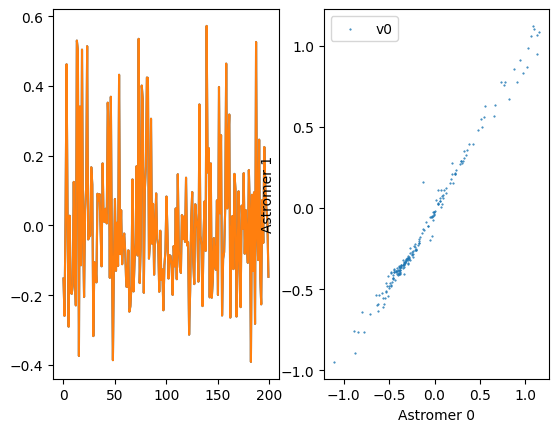

In [91]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(input_0[0], label='v0')
axes[0].plot(input_1[0], label='v1')

axes[1].scatter(output_0[0], output_1[0], label='v0', marker='.', s=1)
axes[1].set_xlabel('Astromer 0')
axes[1].set_ylabel('Astromer 1')
# axes[1].plot(output_1[0], label='v1')

plt.legend()
plt.show()

TensorShape([16, 200, 1])

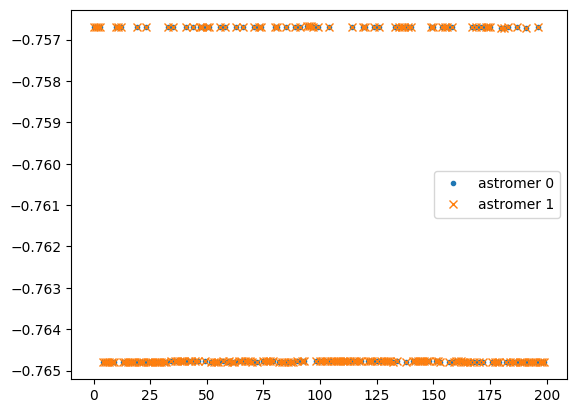

In [71]:
plt.plot(out_0[0], label='astromer 0', marker='.', linestyle='')
plt.plot(out_1[0], label='astromer 1', marker='x', linestyle='')
plt.legend()